In [1]:
from os import sys, path
sys.path.append(path.dirname(path.dirname(path.abspath('__file__'))))
# from utils import (compute_elo_ratting_dataframe_for_champ_v2, compute_elo_ratting_dataframe_for_champ_v3,delete_directory_contents)

In [35]:
import matplotlib.pyplot as plt

In [36]:
%matplotlib inline

In [2]:
from utils import Player, Elo

In [3]:
import datetime
import pandas as pd
import numpy as np
import pickle

In [4]:
import progressbar

In [5]:
import h5py

/home/kasper/PycharmProjects/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
df = pd.read_csv('/home/kasper/Dropbox/Scrapping/soccerway/csv/final_data_soccerway.csv', index_col='Unnamed: 0')
df.loc[:,'date'] = pd.to_datetime(df.date)

In [506]:
input_date = [datetime.datetime(2018,1,29),datetime.datetime(2018,1,30),datetime.datetime(2018,1,31)][:1]
input_data = df[df.date.isin(input_date)]
training_data = df.loc[:input_data.index[0]-1]

### Get Home teams

In [507]:
home_teams = input_data.home_team.dropna().drop_duplicates().values
teams_grouped = df.groupby('home_team').size()
home_teams_consider = teams_grouped[home_teams].sort_values(ascending=False)

### Get Away teams

In [508]:
away_teams = input_data.away_team.dropna().drop_duplicates().values
teams_grouped = df.groupby('away_team').size()
away_teams_consider = teams_grouped[away_teams].sort_values(ascending=False)

In [509]:
threshold_match_number = 100
threshold_champ_number = 1000

In [510]:
home_final_teams = home_teams_consider[home_teams_consider > threshold_match_number].index
away_final_teams = away_teams_consider[away_teams_consider > threshold_match_number].index

In [511]:
new_champs = df.groupby('championship').size()[champs_to_keep].sort_values(ascending=False)
champs = new_champs[new_champs>threshold_champ_number].index.values

In [512]:
final_matches = input_data[(input_data.home_team.isin(home_final_teams)) & (input_data.away_team.isin(away_final_teams)) & (input_data.championship.isin(champs))]

In [513]:
date = final_matches.date.iloc[0].strftime('%Y-%m-%d')
final_matches.to_csv('../data/predict_'+date+'.csv')

In [514]:
def compute_elo_by_goals(data_df, players, all_teams, elo, initial_score=100):
    print('[FUNCTION]: computing elo by goals.')
    """
    This function is used to compute the elo ratings of teams based on goals scored depending on wins and losses.

    :param data_df:
    :param players:
    :param elo:
    :return:
    """
    n_games = data_df.shape[0]
    # does this work for sparce matrix


    print('[INFO] number of games: ', n_games)

    bar = progressbar.ProgressBar(widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ])

    ix = data_df.index
    for i in bar(range(n_games)[:]):
        match = data_df.iloc[i]
        player_home = match.home_team
        player_away = match.away_team
        hid = np.where(all_teams == player_home)[0][0]
        aid = np.where(all_teams == player_away)[0][0]
        pair = [players[hid], players[aid]]
        res = match.result_final
        home_goals = match.home_goals
        away_goals = match.away_goals

        if res == 0:
            for goal_difference in range(int(abs(home_goals-away_goals))):
                a, b = elo.match_algo_strict(pair[0], pair[1])

            a.ys.append(a.score)
            b.ys.append(b.score)
            a.index.append(ix[i])
            b.index.append(ix[i])
        elif res == 2:
            for goal_difference in range(int(abs(home_goals-away_goals))):
                a, b = elo.match(pair[1], pair[0])

            a.ys.append(a.score)
            b.ys.append(b.score)
            a.index.append(ix[i])
            b.index.append(ix[i])
        else:
            pair[0].ys.append(pair[0].score)
            pair[1].ys.append(pair[1].score)
            pair[0].index.append(ix[i])
            pair[1].index.append(ix[i])

    # TODO: convert to pickle. because lossing slashes causes shitstorm.
    dfs = []
    for pl in players:
        df = pd.DataFrame(pl.ys, columns = [pl.name], index=pl.index)
        dfs.append(df)
        del df
    names = [p.name for p in players]
    del players
    return dfs, names

def compute_elo_ratting_dataframe_for_champ_v3(data, champs):
    matches_champ = data[data.championship.isin(champs)]
    ht = matches_champ.home_team.values
    at = matches_champ.away_team.values
    all_teams = np.append(ht, at)
    all_teams = np.unique(all_teams)
    players = [Player(name=p) for p in all_teams]
    elo = Elo()
    dfs, names = compute_elo_by_goals(matches_champ, players, all_teams, elo)
    return dfs, names

In [515]:
# h5f.close()

In [516]:
h5f = h5py.File('./temp/'+date+'.h5','w')
for champ in champs[:]:
    h5f.create_group(champ)
    elo_dfs, teams = compute_elo_ratting_dataframe_for_champ_v3(training_data, [champ])
    for t, team in enumerate(teams):
        ix,vals = elo_dfs[t].index.values,elo_dfs[t].values.reshape(-1)
        h5f.create_dataset(champ+'/'+team, data=np.array([ix,vals]))
h5f.close()

 [Elapsed Time: 0:00:00] |                                   | (ETA:  0:00:43) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  37498


 [Elapsed Time: 0:00:34] |###################################| (Time: 0:00:34) 
 [Elapsed Time: 0:00:00] |                                   | (ETA:  0:00:10) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  10296


 [Elapsed Time: 0:00:08] |###################################| (Time: 0:00:08) 
 [Elapsed Time: 0:00:00] |                                   | (ETA:  0:00:08) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  9003


 [Elapsed Time: 0:00:08] |###################################| (Time: 0:00:08) 
 [Elapsed Time: 0:00:00] |                                   | (ETA:  0:00:06) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  6325


 [Elapsed Time: 0:00:05] |###################################| (Time: 0:00:05) 
 [Elapsed Time: 0:00:00] |#                                  | (ETA:  0:00:04) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  5620


 [Elapsed Time: 0:00:04] |###################################| (Time: 0:00:04) 
 [Elapsed Time: 0:00:00] |#                                  | (ETA:  0:00:04) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  5151


 [Elapsed Time: 0:00:04] |###################################| (Time: 0:00:04) 
 [Elapsed Time: 0:00:00] |#                                  | (ETA:  0:00:03) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  5026


 [Elapsed Time: 0:00:04] |###################################| (Time: 0:00:04) 
 [Elapsed Time: 0:00:00] |#                                  | (ETA:  0:00:02) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  3865


 [Elapsed Time: 0:00:03] |###################################| (Time: 0:00:03) 
 [Elapsed Time: 0:00:00] |#                                  | (ETA:  0:00:02) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  3444


 [Elapsed Time: 0:00:02] |###################################| (Time: 0:00:02) 
 [Elapsed Time: 0:00:00] |#                                  | (ETA:  0:00:02) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  3434


 [Elapsed Time: 0:00:02] |###################################| (Time: 0:00:02) 
 [Elapsed Time: 0:00:00] |#                                  | (ETA:  0:00:02) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  3346


 [Elapsed Time: 0:00:02] |###################################| (Time: 0:00:02) 
 [Elapsed Time: 0:00:00] |#                                  | (ETA:  0:00:02) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  3338


 [Elapsed Time: 0:00:02] |###################################| (Time: 0:00:02) 
 [Elapsed Time: 0:00:00] |##                                 | (ETA:  0:00:02) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  3228


 [Elapsed Time: 0:00:02] |###################################| (Time: 0:00:02) 
 [Elapsed Time: 0:00:00] |##                                 | (ETA:  0:00:01) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  2738


 [Elapsed Time: 0:00:02] |###################################| (Time: 0:00:02) 
 [Elapsed Time: 0:00:00] |##                                 | (ETA:  0:00:02) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  2677


 [Elapsed Time: 0:00:02] |###################################| (Time: 0:00:02) 
 [Elapsed Time: 0:00:00] |##                                 | (ETA:  0:00:02) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  2669


 [Elapsed Time: 0:00:02] |###################################| (Time: 0:00:02) 
 [Elapsed Time: 0:00:00] |###                                | (ETA:  0:00:01) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  2478


 [Elapsed Time: 0:00:02] |###################################| (Time: 0:00:02) 
 [Elapsed Time: 0:00:00] |###                                | (ETA:  0:00:01) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  2011


 [Elapsed Time: 0:00:01] |###################################| (Time: 0:00:01) 
 [Elapsed Time: 0:00:00] |####                               | (ETA:  0:00:01) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  1861


 [Elapsed Time: 0:00:01] |###################################| (Time: 0:00:01) 
 [Elapsed Time: 0:00:00] |###                                | (ETA:  0:00:01) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  1809


 [Elapsed Time: 0:00:01] |###################################| (Time: 0:00:01) 
 [Elapsed Time: 0:00:00] |#####                              | (ETA:  0:00:00) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  1508


 [Elapsed Time: 0:00:01] |###################################| (Time: 0:00:01) 
 [Elapsed Time: 0:00:00] |####                               | (ETA:  0:00:01) 

[FUNCTION]: computing elo by goals.
[INFO] number of games:  1254


 [Elapsed Time: 0:00:01] |###################################| (Time: 0:00:01) 


In [517]:
h5f = h5py.File('./temp/'+date+'.h5','r')

In [518]:
# i=0
gs = []
for i in range(final_matches.shape[0]):
    try:
        print(i)
        ch = final_matches.championship.values[i]
        ht = final_matches.home_team.values[i]
        at = final_matches.away_team.values[i]

        home_elo = pd.DataFrame(h5f[ch][ht][1][:], index=h5f[ch][ht][0][:].astype(int))
        away_elo = pd.DataFrame(h5f[ch][at][1][:], index=h5f[ch][at][0][:].astype(int))

        hte = training_data.loc[home_elo.index]
        ate = training_data.loc[away_elo.index]


        a = hte[(hte.home_team==ht) & ((ate.away_team==at))]

        g = pd.concat([home_elo.loc[a.index],away_elo.loc[a.index],a.result_final],axis=1)
        g.columns = ['he','ae','rf']

        g['check'] = g.he > g.ae
        gs.append(g)
        
    except Exception as e:
        print(e)
        pass

0


/home/kasper/PycharmProjects/venv/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1
2
3
4
5
6
7
8
9
10
11
12


In [519]:
h5f.close()

In [520]:
gs

[                he          ae   rf  check
 1595882  52.128649   59.797515  2.0  False
 1799253  97.073760  102.459674  0.0  False, Empty DataFrame
 Columns: [he, ae, rf, check]
 Index: [],                  he         ae   rf check
 926534    68.200344  60.319110  0.0  True
 1901838  107.552436  54.796629  2.0  True,                he         ae   rf check
 711082  56.406508  12.981062  0.0  True,                  he          ae   rf  check
 21501    123.584755  178.247869  0.0  False
 32998    133.135228  154.218905  1.0  False
 70451    143.447612  337.208560  2.0  False
 91893    102.413661  368.521889  2.0  False
 129587   131.342931  362.924677  0.0  False
 209080   145.452852  358.945458  2.0  False
 270719   146.892064  367.772849  2.0  False
 358010   188.260638  407.438019  0.0  False
 484664   163.912463  411.752206  1.0  False
 570172   109.595148  413.365320  2.0  False
 1282578   37.773127  592.943865  2.0  False
 1502208   92.408014  644.696845  2.0  False
 1646271   74.

In [521]:
dfa = pd.concat(gs)

In [522]:
dfa.shape

(56, 4)

In [523]:
from sklearn.model_selection import train_test_split

In [524]:
from sklearn import svm

In [525]:
from sklearn import linear_model



In [526]:
X_train, X_test, y_train, y_test = train_test_split(dfa[['he','ae']], dfa.rf.values, test_size=0.25, random_state=0)

In [527]:
# clf = svm.SVC(kernel='linear', C=1)
clf = linear_model.LogisticRegression(C=1e5)
clf.fit(X_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [528]:
clf.score(X_test, y_test)                           

0.42857142857142855

In [529]:
from sklearn.model_selection import cross_val_score

In [530]:
from sklearn.model_selection import cross_validate

In [531]:
clf = svm.SVC(kernel='linear', C=1)

In [532]:
scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(clf, dfa[['he','ae']], dfa.rf, cv=3,scoring=scoring)

In [533]:
scores

/home/kasper/PycharmProjects/venv/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_precision_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/kasper/PycharmProjects/venv/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_recall_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.11748171, 0.0967288 , 0.12554026]),
 'score_time': array([0.00306296, 0.00308919, 0.00301528]),
 'test_precision_macro': array([0.34848485, 0.61111111, 0.45555556]),
 'test_recall_macro': array([0.36428571, 0.58571429, 0.28412698]),
 'train_precision_macro': array([0.44444444, 0.50543024, 0.61416361]),
 'train_recall_macro': array([0.47380952, 0.48290598, 0.59487179])}

,he,ae,rf,check
1014,95.000000,105.000000,2.0,False
16807,244.639153,75.892815,0.0,True
24786,293.970142,91.306364,0.0,True
29607,296.355943,95.453030,0.0,True
40152,353.178793,80.718458,0.0,True
61250,413.042751,81.881285,0.0,True
70609,426.641511,108.765897,0.0,True
83428,452.753556,95.914657,0.0,True
96932,502.741534,108.347757,1.0,True
119664,506.030196,93.017785,0.0,True


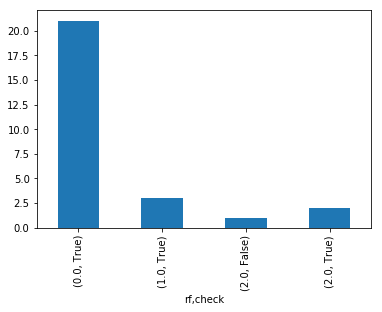

In [371]:
g.groupby(['rf','check']).size().plot(kind='bar')

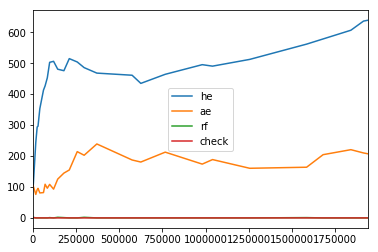

In [339]:
g.plot()

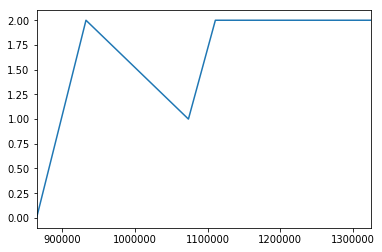

In [318]:
g.rf.plot()

In [228]:
h5f.close()

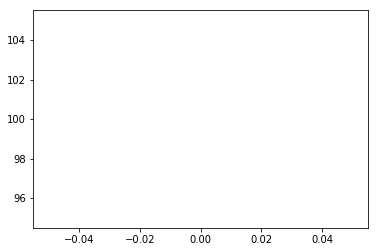

In [ ]:
elo_df[1]

In [ ]:
len(teams)